<a href="https://colab.research.google.com/github/kr7/diw/blob/main/DIW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Number of nearest neighbors in the experiment

Parameter of the k-nearest neighbor classifier


In [ ]:
k = 1 

# Imports

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from google.colab import widgets
from time import time

# Load and Prepare the Data

In [ ]:
data = np.loadtxt('https://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data')

In [ ]:
original_img_size = (16, 16)
new_img_size = (8,8)

data_8x8 = []
for i in range(len(data)):
  img_16x16 = np.reshape(data[i,0:256], original_img_size)
  img_8x8 = cv2.resize(img_16x16, new_img_size)
  data_8x8.append( img_8x8 )

data_8x8 = np.array(data_8x8)

In [ ]:
tb = widgets.TabBar([str(i) for i in range(10)], location='top')
for i in range(10):
  with tb.output_to(i):
    plt.figure(figsize=(2,2))
    plt.imshow(1-data_8x8[i*20], cmap='gray', vmin=0, vmax=1)
    plt.show()

# Dynamic Image Warping 

Implementation of DIW with Cython type annotations for efficiency

In [ ]:
%load_ext cython

In [ ]:
%%cython

import numpy as np
cimport numpy as np

def dtw(np.ndarray[np.float_t, ndim=1] ts1, 
        np.ndarray[np.float_t, ndim=1] ts2):
  
  cdef int LEN_TS1 
  cdef int LEN_TS2
  cdef int i
  cdef int j
  cdef np.ndarray[np.float_t, ndim=2] dtw_matrix

  LEN_TS1 = len(ts1)
  LEN_TS2 = len(ts2)

  dtw_matrix = np.zeros( (LEN_TS1, LEN_TS2), dtype=float )
  
  dtw_matrix[0,0] = abs(ts1[0]-ts2[0])
  
  for i in range(1, LEN_TS1):
    dtw_matrix[i,0] = dtw_matrix[i-1,0]+abs(ts1[i]-ts2[0])

  for j in range(1, LEN_TS2):
    dtw_matrix[0,j] = dtw_matrix[0,j-1]+abs(ts1[0]-ts2[j])

  for i in range(1, LEN_TS1):
    for j in range(1, LEN_TS2):
      dtw_matrix[i,j] = min(dtw_matrix[i-1,j-1], dtw_matrix[i-1,j], 
                            dtw_matrix[i, j-1]) + abs(ts1[i]-ts2[j])
  
  return dtw_matrix[ len(ts1)-1, len(ts2)-1 ]

def diw(np.ndarray[np.float_t, ndim=2] img1, 
        np.ndarray[np.float_t, ndim=2] img2):
  
  cdef int LEN_IMG1 
  cdef int LEN_IMG2
  cdef int i
  cdef int j
  cdef np.ndarray[np.float_t, ndim=2] diw_matrix

  LEN_IMG1 = len(img1)
  LEN_IMG2 = len(img2)

  diw_matrix = np.zeros( (LEN_IMG1, LEN_IMG2), dtype=float )
  
  diw_matrix[0,0] = dtw(img1[0], img2[0])
  
  for i in range(1, LEN_IMG1):
    diw_matrix[i,0] = diw_matrix[i-1,0]+dtw(img1[i], img2[0])

  for j in range(1, LEN_IMG2):
    diw_matrix[0,j] = diw_matrix[0,j-1]+dtw(img1[0], img2[j])

  for i in range(1, LEN_IMG1):
    for j in range(1, LEN_IMG2):
      diw_matrix[i,j] = min(diw_matrix[i-1,j-1], diw_matrix[i-1,j], 
                            diw_matrix[i, j-1]) + dtw(img1[i], img2[j])
  
  return diw_matrix[ LEN_IMG1-1, LEN_IMG2-1 ]

# Main Experiment Loop

In [ ]:
time0 = time()

progress = widgets.Grid(1, 1)

accuracies = []

for number_of_training_instances_from_each_class in range(1,21):

  if number_of_training_instances_from_each_class > 20:
    raise Exception("The number of training instances from each class can not "
                    "be more than 20 in the current implementation")

  train_indices = []
  for i in range(10):
    for j in range(number_of_training_instances_from_each_class):
      train_indices.append(20*i+j)

  train_data = data_8x8[ train_indices ]
  train_labels = data[ train_indices ,256:266]

  # last 1000 images are used as test data
  test_data = data_8x8[593:]
  test_labels = data[593:,256:266]

  acc = []
  for metric in ['diw', 'euclidean', 'manhattan']:
    correct = 0
    for i in range(len(test_data)):
      distances = []
      for j in range(len(train_data)):

        if metric == 'diw':
           d = diw(test_data[i], train_data[j]) + diw(np.transpose(test_data[i]), 
                                                  np.transpose(train_data[j]))
        elif metric == 'euclidean':
          d = np.sum( (test_data[i] - train_data[j])**2 )
        elif metric == 'manhattan':
          d = np.sum( np.abs(test_data[i] - train_data[j]) )

        distances.append(d)
      
      nn_indices = np.argpartition(distances,k)[:k]

      pred_scores = np.zeros( (len(train_labels[0])) )
      
      for j in nn_indices:
        pred_scores = pred_scores + train_labels[j]

      if np.argmax(pred_scores) == np.argmax(test_labels[i]):
        correct = correct + 1
      
      if (i+1)%100 == 0:
        with progress.output_to(0, 0):
          progress.clear_cell()
          print(f'#training: {number_of_training_instances_from_each_class}   metric: {metric}   acc: {correct}/{i+1}={correct/(i+1):.3f}')
      
    acc.append( correct/(i+1) )

  accuracies.append( acc )

time1 = time()
print(f"Execution time: {int(time1-time0)}")

# Results

Plot the accuracy as function of the number of training instances from each class

In [ ]:
accuracies = np.array(accuracies)

figure(figsize=(6, 4), dpi=100)

x = range(1,len(accuracies)+1) 
plt.plot( x , accuracies[:,0], 'o-', label='DIW')
plt.plot( x , accuracies[:,1], '--', label='Euclidean')
plt.plot( x , accuracies[:,2], 'x:', label='Manhattan')
plt.title(f"k={k}")
plt.xticks(list(range(1,21,2)))
plt.xlabel("Number of training instances from each class")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

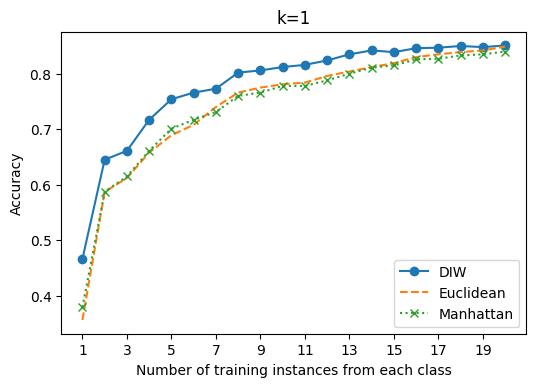

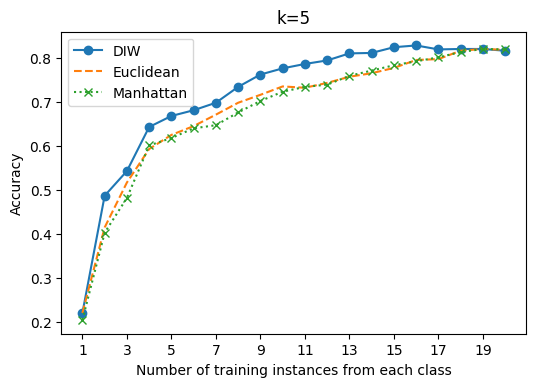